<a href="https://colab.research.google.com/github/p2yeong/HACHATHON/blob/main/hackathon_1st/%5BEDA%5DRestaurant_visitor_Forecasting_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime
import os
import glob, re
import time, datetime
from datetime import timedelta

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 데이터 전처리

In [ ]:
dir_path = '/content/drive/MyDrive/Hackathon01'
data = {
    'tra': pd.read_csv(dir_path + '/air_visit_data.csv'),
    'as': pd.read_csv(dir_path + '/air_store_info.csv'),
    'hs': pd.read_csv(dir_path + '/hpg_store_info.csv'),
    'ar': pd.read_csv(dir_path + '/air_reserve.csv'),
    'hr': pd.read_csv(dir_path + '/hpg_reserve.csv'),
    'id': pd.read_csv(dir_path + '/store_id_relation.csv'),
    'tes': pd.read_csv(dir_path+  '/sample_submission.csv'),
    'hol': pd.read_csv(dir_path +  '/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [ ]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])# bring air id to hpg reserve data
data['hs'] = pd.merge(data['hs'], data['id'], how='inner', on=['hpg_store_id'])# bring air id to hpg stores

In [ ]:
print('Data structure.......................')
print('Training data....',data['tra'].shape)
print('Unique store id in training data',len(data['tra']['air_store_id'].unique()))
print('Id data....',data['id'].shape)
print('Air store data....',data['as'].shape,'& unique-',data['as']['air_store_id'].unique().shape)
print('Hpg store data....',data['hs'].shape,'& unique-',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data....',data['ar'].shape,'& unique-',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data....',data['hr'].shape,'& unique-',data['hr']['air_store_id'].unique().shape)

Data structure.......................
Training data.... (252108, 3)
Unique store id in training data 829
Id data.... (150, 2)
Air store data.... (829, 5) & unique- (829,)
Hpg store data.... (63, 6) & unique- (63,)
Air reserve data.... (92378, 4) & unique- (314,)
Hpg reserve data.... (28183, 5) & unique- (150,)


In [ ]:
#converting datetime to date for reservation data
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_hour'] = data[df]['visit_datetime'].dt.hour
    data[df]['visit_date'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_hour'] = data[df]['reserve_datetime'].dt.hour
    data[df]['reserve_date'] = data[df]['reserve_datetime'].dt.date
    
    data[df+'_hour'] = data[df]#keeping original

    #calculate reserve time difference and summarizing ar,hr to date
    data[df]['reserve_day_'+df] = data[df].apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_date'], as_index=False)[[
        'reserve_day_'+df, 'reserve_visitors']].sum().rename(columns={'reserve_visitors':'reserve_visitors_'+df})

In [ ]:
data['ar'] # 몇일 전에 예약했는지, 예약 인원수

,air_store_id,visit_date,reserve_day_ar,reserve_visitors_ar
0,air_00a91d42b08b08d9,2016-10-31,0,2
1,air_00a91d42b08b08d9,2016-12-05,4,9
2,air_00a91d42b08b08d9,2016-12-14,6,18
3,air_00a91d42b08b08d9,2016-12-17,6,2
4,air_00a91d42b08b08d9,2016-12-20,2,4
...,...,...,...,...
29825,air_fea5dc9594450608,2017-04-22,0,2
29826,air_fea5dc9594450608,2017-04-25,9,2
29827,air_fea5dc9594450608,2017-04-28,29,3
29828,air_fea5dc9594450608,2017-05-20,34,6


In [ ]:
#breaking down dates on training data & summarizing 
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['day'] = data['tra']['visit_date'].dt.day
data['tra']['dow'] = data['tra']['visit_date'].dt.weekday # monday:0, sunday:6
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['week'] = data['tra']['visit_date'].dt.week
data['tra']['quarter'] = data['tra']['visit_date'].dt.quarter
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)

In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors,day,dow,dow_name,year,month,week,quarter,year_mth
0,air_ba937bf13d40fb24,2016-01-13,25,13,2,Wednesday,2016,1,2,1,2016-1
1,air_ba937bf13d40fb24,2016-01-14,32,14,3,Thursday,2016,1,2,1,2016-1
2,air_ba937bf13d40fb24,2016-01-15,29,15,4,Friday,2016,1,2,1,2016-1
3,air_ba937bf13d40fb24,2016-01-16,22,16,5,Saturday,2016,1,2,1,2016-1
4,air_ba937bf13d40fb24,2016-01-18,6,18,0,Monday,2016,1,3,1,2016-1


In [ ]:
#extracting store id and date info from test data
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['day'] = data['tes']['visit_date'].dt.day
data['tes']['dow'] = data['tes']['visit_date'].dt.weekday
data['tes']['dow_name'] = data['tes']['visit_date'].dt.day_name()
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['week'] = data['tes']['visit_date'].dt.week
data['tes']['quarter'] = data['tes']['visit_date'].dt.quarter
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes']['year_mth'] = data['tes']['year'].astype(str)+'-'+data['tes']['month'].astype(str)

In [ ]:
data['tes'].head()

,id,visitors,air_store_id,visit_date,day,dow,dow_name,year,month,week,quarter,year_mth
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,23,6,Sunday,2017,4,16,2,2017-4
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,24,0,Monday,2017,4,17,2,2017-4
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,25,1,Tuesday,2017,4,17,2,2017-4
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,26,2,Wednesday,2017,4,17,2,2017-4
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,27,3,Thursday,2017,4,17,2,2017-4


In [ ]:
#extract unique stores based on test data and populate dow 1 to 6
unique_stores = data['tes']['air_store_id'].unique()#extract unique stores id from test data

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [ ]:
len(unique_stores)

821

In [ ]:
store_7days

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0
...,...,...
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6


In [ ]:
store_sum

,air_store_id
0,air_00a91d42b08b08d9
1,air_0164b9927d20bcc3
2,air_0241aa3964b7f861
3,air_0328696196e46f18
4,air_034a3d5b40d5b1b1
...,...
816,air_fea5dc9594450608
817,air_fee8dcf4d619598e
818,air_fef9ccb3ba0da2f7
819,air_ffcc2d5087e1b476


In [ ]:
# mapping train data dow to stores(test data) - min, mean, median, max, count 
tmp = data['tra'].groupby(['air_store_id'], as_index=False)[
    'visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

In [ ]:
# map stores(test) to store genre and location detail
store_7days = pd.merge(store_7days, data['as'], how='left', on=['air_store_id']) 

In [ ]:
#map to hpg genre and area
store_7days = pd.merge(store_7days, data['hs'][['air_store_id','hpg_genre_name','hpg_area_name']], 
                       how='left', on=['air_store_id']) 

In [ ]:
store_7days[store_7days['air_store_id']=='air_00a91d42b08b08d9']

,air_store_id,dow,total_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,hpg_genre_name,hpg_area_name
0,air_00a91d42b08b08d9,0,6051,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN
821,air_00a91d42b08b08d9,1,6051,24.350000,24.5,43.0,40.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN
1642,air_00a91d42b08b08d9,2,6051,28.125000,28.0,52.0,40.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN
2463,air_00a91d42b08b08d9,3,6051,29.868421,30.0,47.0,38.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN
3284,air_00a91d42b08b08d9,4,6051,36.500000,35.5,57.0,40.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN
4105,air_00a91d42b08b08d9,5,6051,14.973684,11.0,99.0,38.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN
4926,air_00a91d42b08b08d9,6,6051,2.000000,2.0,2.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,NaN,NaN


In [ ]:
#map to hpg genre and area
store_7days = pd.merge(store_7days, data['hs'][['air_store_id','hpg_genre_name','hpg_area_name']], 
                       how='left', on=['air_store_id']) 

In [ ]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

In [ ]:
# 월요일, 금요일이 휴일인경우 주말포함해 쉬니까, long_wknd 컬럼 추가해서 표시해주기
hf=data['hol']['holiday_flg']
dw=data['hol']['day_of_week']
data['hol']['long_wknd']=0

for i in range(len(data['hol'])):
    if (hf[i]==1)&(dw[i]=='Friday'):
        data['hol']['long_wknd'][i]=1
        data['hol']['long_wknd'][i+1]=1
        data['hol']['long_wknd'][i+2]=1
          
    if (hf[i]==1)&(dw[i]=='Monday'):
        data['hol']['long_wknd'][i]=1
        data['hol']['long_wknd'][i-1]=1
        data['hol']['long_wknd'][i-2]=1

In [ ]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 
train = pd.merge(train, store_7days, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, store_7days, how='left', on=['air_store_id','dow'])

In [ ]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

In [ ]:
#calculate qoq(QoQ는 Quarter on Quarter,  직전 분기 대비 증감율)
qoq= train.groupby(['air_store_id','year','quarter'])['visitors'].sum()
qoq=qoq.unstack(0)
qoq=pd.DataFrame(qoq.to_records())
qoq=qoq.transpose()
qoq.drop(['year','quarter'],inplace=True)
qoq['2016Q2']=qoq[1]/qoq[0]*100
qoq['2016Q3']=qoq[2]/qoq[1]*100
qoq['2016Q4']=qoq[3]/qoq[2]*100
qoq['2017Q1']=qoq[4]/qoq[3]*100
lst=['2016Q2','2016Q3','2016Q4','2017Q1']
qoq=qoq[lst]
qoq['qoq_count']=qoq.apply(lambda x: x.count(), axis=1) 
qoq['qoq_growth']=qoq.apply(lambda x: x[x>100].count(), axis=1)
qoq['qoq_growth_pct'] = round(qoq['qoq_growth'] /qoq['qoq_count'],2)
qoq.index.names=['air_store_id']
qoq.reset_index(inplace=True)


In [ ]:
qoq.head()

,air_store_id,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth,qoq_growth_pct
0,air_00a91d42b08b08d9,NaN,NaN,97.752809,117.298851,2,1,0.50
1,air_0164b9927d20bcc3,NaN,NaN,NaN,94.577352,1,0,0.00
2,air_0241aa3964b7f861,95.769683,87.484663,109.116410,75.449871,4,1,0.25
3,air_0328696196e46f18,NaN,NaN,42.810458,286.259542,2,1,0.50
4,air_034a3d5b40d5b1b1,NaN,NaN,80.883978,217.486339,2,1,0.50


In [ ]:
train=pd.merge(train, qoq, how='left', on='air_store_id')

In [ ]:
# 결측치 0으로 처리
train = train.fillna(0) #change to one for algo training
test = test.fillna(0)

In [ ]:
train['v_no_reservation']=train['visitors']-train['reserve_visitors_ar']-train['reserve_visitors_hr']

In [ ]:
# 각 데이터의 날짜 범위
print('Dates................')
print('train date- ,',train['visit_date'].min(),' to ',train['visit_date'].max())
print('test date - ,',test['visit_date'].min(),' to ',test['visit_date'].max())
print('holiday df- ,',data['hol']['visit_date'].min(),' to ',data['hol']['visit_date'].max())

Dates................
train date- , 2016-01-01  to  2017-04-22
test date - , 2017-04-23  to  2017-05-31
holiday df- , 2016-01-01  to  2017-05-31


# 데이터 시각화

## 예측 기간의 쉬는날(휴일 및 주말)

Text(0.5, 1.0, 'April & May 2017 Holidays & Weekends')

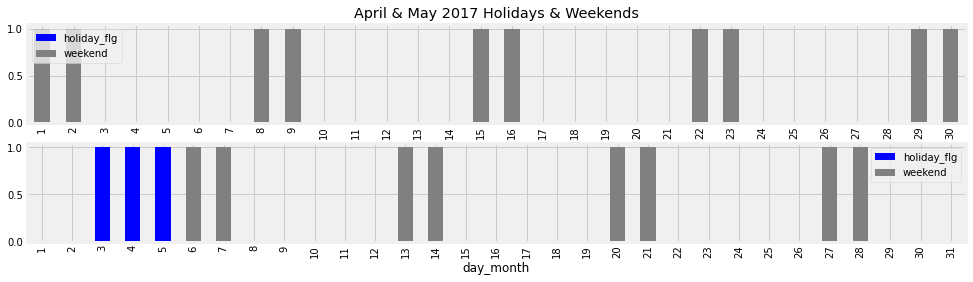

In [ ]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_month'] = data['hol']['visit_date'].dt.day
data['hol']['day'] = data['hol']['visit_date'].dt.weekday
data['hol']['week'] = data['hol']['visit_date'].dt.week
data['hol']['month'] = data['hol']['visit_date'].dt.month
data['hol']['quarter'] = data['hol']['visit_date'].dt.quarter
data['hol']['year'] = data['hol']['visit_date'].dt.year
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

def wkn(x):
    if x>4:
        return 1
    else:
        return 0

data['hol']['weekend']=data['hol']['day'].apply(wkn)

# 2017년 4월& 5월 공휴일, 주말 데이터 프레임 만들기
hols201704=data['hol'][(data['hol']['year']==2017)&(data['hol']['month']==4)]
hols=hols201704[['day_month','holiday_flg']].set_index('day_month')
wknd=hols201704[['day_month','weekend']].set_index('day_month')
hols201705=data['hol'][(data['hol']['year']==2017)&(data['hol']['month']==5)]
hols2=hols201705[['day_month','holiday_flg']].set_index('day_month')
wknd2=hols201705[['day_month','weekend']].set_index('day_month')

f, ax=plt.subplots(2,1, figsize=(15,4))
hols.plot(kind='bar', ax=ax[0], color='b')
wknd.plot(kind='bar', ax=ax[0], color='grey')
hols2.plot(kind='bar', ax=ax[1], color='b')
wknd2.plot(kind='bar', ax=ax[1], color='grey')
ax[0].set_title('April & May 2017 Holidays & Weekends')

예측 기간에는 3일의 공휴일이 포함되어 있다.

## 방문객 추이

Text(0.5, 1.0, 'Visitor and Reservations')

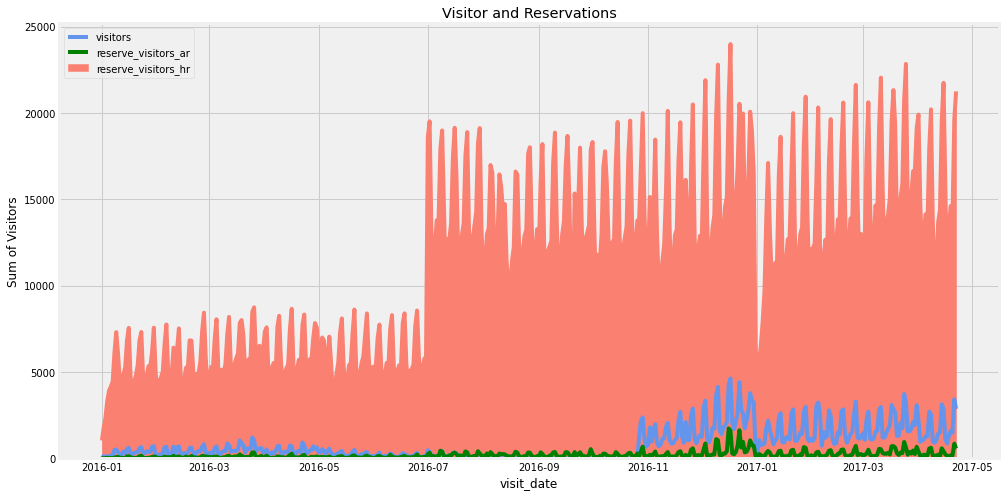

In [ ]:
# visitor each day
f,ax = plt.subplots(1,1,figsize=(15,8))
plt1 = train.groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})
plt2 = train.groupby(['visit_date'], as_index=False).agg({'reserve_visitors_ar': np.sum})
plt3 = train.groupby(['visit_date'], as_index=False).agg({'reserve_visitors_hr': np.sum})
plt1=plt1.set_index('visit_date')
plt2=plt2.set_index('visit_date')
plt3=plt3.set_index('visit_date')
plt1.plot(color='salmon', kind='area', ax=ax)
plt2.plot(color='cornflowerblue', kind='line', ax=ax)
plt3.plot(color='g', kind='line', ax=ax)
plt.ylabel("Sum of Visitors")
plt.title("Visitor and Reservations")

- 2016년 7월에 총 방문객 수의 큰폭의 상승
- 2017년 1월에 큰 하락폭 존재
- 총 방문객 수의 패턴이 존재(일정 간격으로 패턴 반복)
- 예약없이 방문하는 방문객이 훨씬 많은 편

Text(0.5, 1.0, 'Number Unique Store ID')

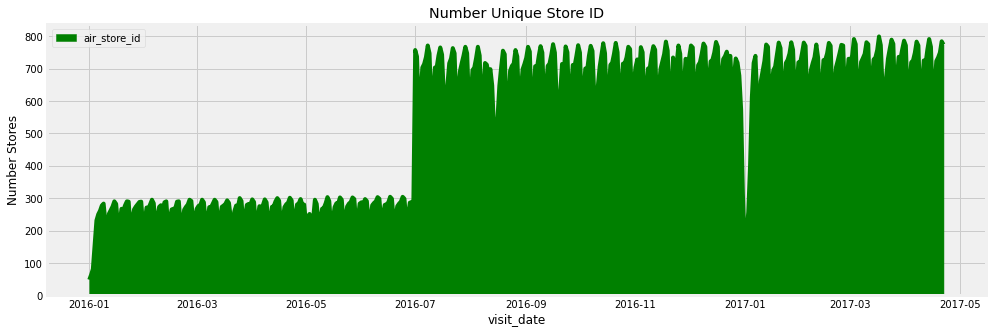

In [ ]:
f,ax = plt.subplots(1,1, figsize=(15,5))
genre= train.groupby(['visit_date'])['air_store_id'].size()
genre.plot(kind='area',  color= 'g', grid=True, ax=ax, legend=True)
plt.ylabel("Number Stores")
plt.title("Number Unique Store ID")

- 2016년 7월에 store_id의 수가 크게 증가.(추적할 수 있는 데이터가 증가해 위와 같은 경향을 보인 것 같다.)

Text(0.5, 1.0, 'Number Unique Store ID')

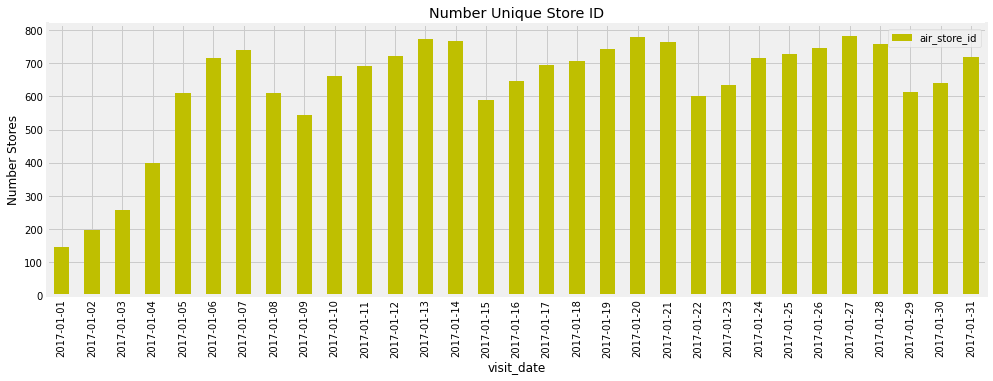

In [ ]:
store201701 = data['tra'][(data['tra']['year']==2017) & (data['tra']['month']==1)]
f,ax = plt.subplots(1,1, figsize=(15,5))
genre= store201701.groupby(['visit_date'])['air_store_id'].size()
genre.plot(kind='bar',  color= 'y', grid=True, ax=ax, legend=True)
plt.ylabel("Number Stores")
plt.title("Number Unique Store ID")

2017년 1월에 큰 방문객의 급격한 감소는 새해에 문을 닫는 가게가 많기 때문에 발생한 것으로 판단됨

## 장르 별 방문객 추이

Text(0, 0.5, 'air_genre_name')

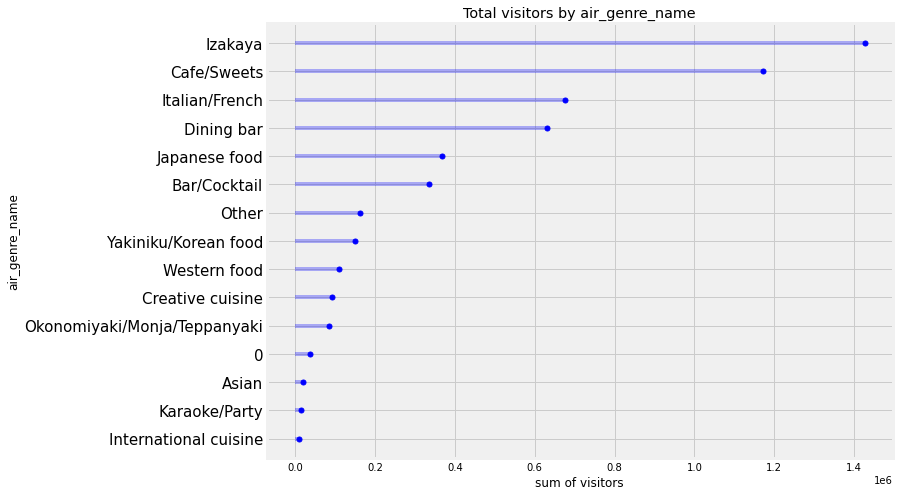

In [ ]:
f,ax=plt.subplots(1,1, figsize=(10,8))
genre=train.groupby(['air_genre_name'],as_index=False)['visitors'].sum()
genre.sort_values(by='visitors', ascending=True, inplace=True)
genre['air_genre'] =[i for i,x in enumerate(genre['air_genre_name'])] 
genre = genre.sort_values(by='visitors', ascending=False)#.reset_index()
my_range = genre['air_genre']
plt.hlines(y=my_range, xmin=0, xmax=genre['visitors'], color='b',alpha=0.3) #[‘solid’ | ‘dashed’ | ‘dashdot’ | ‘dotted’]
plt.plot(genre['visitors'], my_range, "o",markersize=5,label='visitors',color='b')

# Add titles and axis names
plt.yticks(my_range, genre['air_genre_name'],fontsize=15)
plt.title("Total visitors by air_genre_name", loc='center')
plt.xlabel('sum of visitors')
plt.ylabel('air_genre_name')
#plt.legend()

총 방문객 수로 살펴본 인기 레스토랑 장르(카테고리)는 Izakaya와 Cafe/Sweets 이다. 방문객이 선호하는 장르가 존재한다.

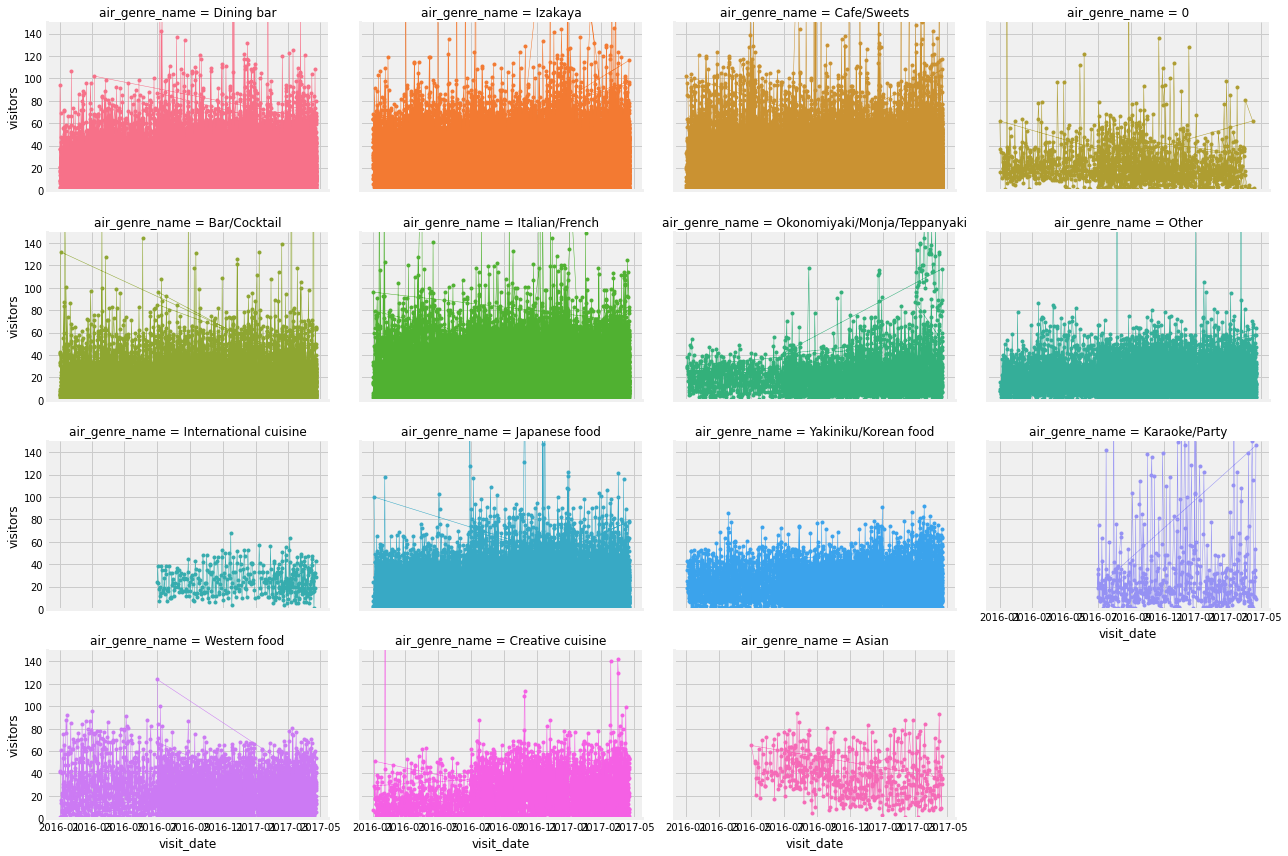

In [ ]:
ax = sns.FacetGrid(train, col="air_genre_name", col_wrap=4, size=3, hue='air_genre_name',margin_titles=True,
                  aspect=1.5, palette='husl', ylim=(0,150))
ax = ax.map(plt.plot, "visit_date", "visitors",  marker=".", linewidth = 0.5)

- International cuisine, Karaoke/Party, Asian 장르는 새롭게 나타난 장르
- Karaokr/Party는 방문자수가 급격히 증가하는 시기가 있다.
- 0 장르는 결측치

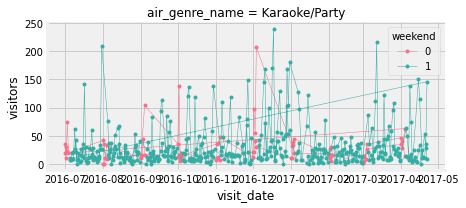

In [ ]:
visit_karaoke = train[train['air_genre_name']== 'Karaoke/Party']
visit_karaoke['weekend']=visit_karaoke['day'].apply(wkn)
visit_karaoke.head()

ax = sns.FacetGrid(visit_karaoke, col="air_genre_name", col_wrap=4, size=3, hue='weekend',margin_titles=True,
                  aspect=2, palette='husl', legend_out=False)
ax = ax.map(plt.plot, "visit_date", "visitors",  marker=".", linewidth = 0.5)
ax.add_legend()

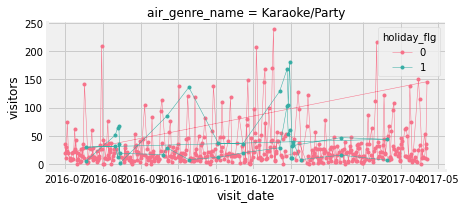

In [ ]:
ax = sns.FacetGrid(visit_karaoke, col="air_genre_name", col_wrap=4, size=3, hue='holiday_flg',margin_titles=True,
                  aspect=2, palette='husl', legend_out=False)
ax = ax.map(plt.plot, "visit_date", "visitors",  marker=".", linewidth = 0.5)
ax.add_legend()

Karaokr/Party는 주말에 방문자수가 급격히 증가한다.(공휴일과 방문자수는 상관없다.)

## 요일 별 평균 방문 추이

In [ ]:
# 월 기준 요일별 평균 방문자수 테이블 만들기
pvt=pd.pivot_table(train, index=['year','week'], columns='dow',values='visitors',aggfunc=[np.mean],fill_value=0)
pvt=pd.DataFrame(pvt.to_records())
pvt.columns=[pvt.replace("('mean', ", "").replace(")", "") for pvt in pvt.columns]
pvt['year_week']=pvt['year'].astype(str) +'-'+ pvt['week'].astype(str)
pvt=pvt.set_index('year_week')
pvt.drop(['year','week'], axis=1,inplace=True)
pvt['mean_visitor'] = 20.97

Text(0.5, 1.0, 'Visitors by Day of the Week ')

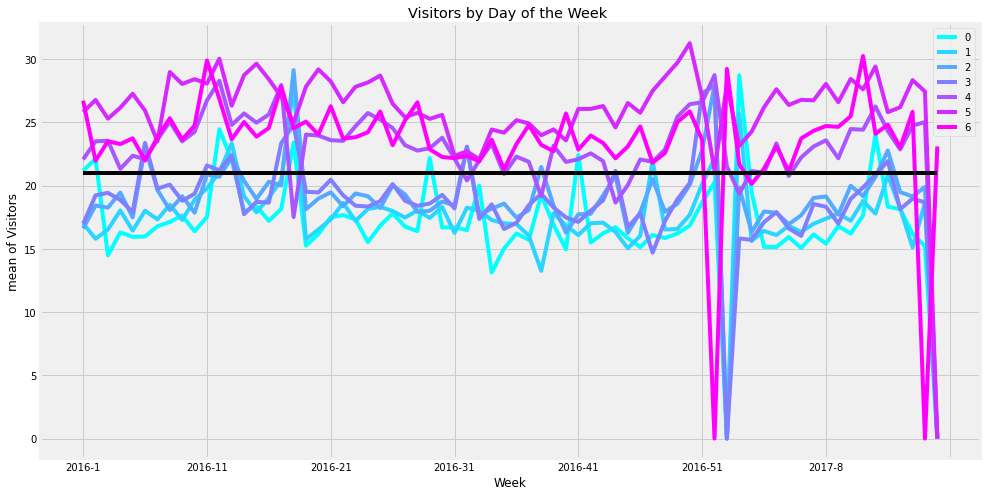

In [ ]:
# 추이 그래프
f, ax=plt.subplots(1,1, figsize=(15,8))
pvt.iloc[:,:-1].plot(kind='line', ax=ax,cmap='cool')
pvt.iloc[:,-1].plot(kind='line', ax=ax,color='black')
plt.ylabel("mean of Visitors")
plt.xlabel("Week")
plt.title("Visitors by Day of the Week ")

In [ ]:
print('Number of total visitors- ', train['visitors'].sum())
print('Number of average daily visitors per air_store_id-', round(train['visitors'].mean(),2))

Number of total visitors-  5287653
Number of average daily visitors per air_store_id- 20.97


In [ ]:
datetime.timedelta(days=364)

datetime.timedelta(days=364)

평일보다 금,토,일의 평균 방문자 수가 높은편이다.

In [ ]:
max_date=max(train['visit_date'])
one_year = datetime.timedelta(days=364)
cmap='cool'
year_ago= max_date - one_year
train2=train#[train['visit_date']>year_ago]
pvt=train2.groupby(['dow','dow_name'])['visitors'].mean().reset_index()
pvt

,dow,dow_name,visitors
0,0,Monday,17.177009
1,1,Tuesday,17.672137
2,2,Wednesday,19.230121
3,3,Thursday,18.922702
4,4,Friday,23.072737
5,5,Saturday,26.313688
6,6,Sunday,23.873362


In [ ]:
train2=train.loc[(train['day']<8)&(train['holiday_flg']==1)]
pvt2=train2.groupby(['dow','dow_name'])['visitors'].mean().reset_index()
pvt2

,dow,dow_name,visitors
0,0,Monday,28.729592
1,1,Tuesday,26.761341
2,2,Wednesday,29.136752
3,3,Thursday,22.118943
4,4,Friday,21.520833
5,5,Saturday,28.000000
6,6,Sunday,25.280702


In [ ]:
train3=train.loc[train['holiday_flg']==1]
pvt3=train3.groupby(['dow','dow_name'])['visitors'].mean().reset_index()
pvt3

,dow,dow_name,visitors
0,0,Monday,21.869048
1,1,Tuesday,26.761341
2,2,Wednesday,22.741722
3,3,Thursday,23.054331
4,4,Friday,27.436732
5,5,Saturday,24.338269
6,6,Sunday,24.882293


In [ ]:
train4=train.loc[(train['long_wknd']==1)]
pvt4=train4.groupby(['dow','dow_name'])['visitors'].mean().reset_index()
pvt4

,dow,dow_name,visitors
0,0,Monday,21.869048
1,4,Friday,27.436732
2,5,Saturday,25.120465
3,6,Sunday,25.520943


In [ ]:
pvt5=pd.pivot_table(train, index=['dow'], columns='month',values='visitors',aggfunc=[np.mean],fill_value=0)#.reset_index()
pvt5=pd.DataFrame(pvt5.to_records())
pvt5.columns=[pvt5.replace("('mean', ", "").replace(")", "") for pvt5 in pvt5.columns]
pvt5=pvt5.set_index('dow')
pvt5

,1,2,3,4,5,6,7,8,9,10,11,12
dow,,,,,,,,,,,,
0,17.441447,16.121593,19.152420,16.979826,18.050719,16.870103,17.815154,16.129932,16.939091,17.029565,15.732065,18.032992
1,16.995078,17.252227,19.130228,17.936027,19.095026,17.921288,17.823872,17.348241,16.106105,16.774811,17.218732,19.155602
2,17.908252,18.580670,20.104312,19.649924,21.114846,19.037245,18.499825,19.227612,18.866502,17.767384,18.673631,22.338732
3,17.234303,18.153846,19.993023,18.959495,20.901099,18.984028,18.766802,19.244083,17.926983,17.868875,17.538301,22.234490
4,21.631802,22.657772,24.647690,24.822240,22.307820,24.808775,23.454617,21.994625,21.492080,22.117001,20.674976,25.863912
5,25.546657,26.835913,28.191810,27.298032,27.594850,27.828692,25.703306,22.904845,24.570000,25.292553,26.101396,28.431343
6,22.399486,23.558651,26.236527,24.479970,25.561308,24.417497,24.043256,22.536486,23.178526,23.744194,22.934165,24.274847


(0.0, 30.0)

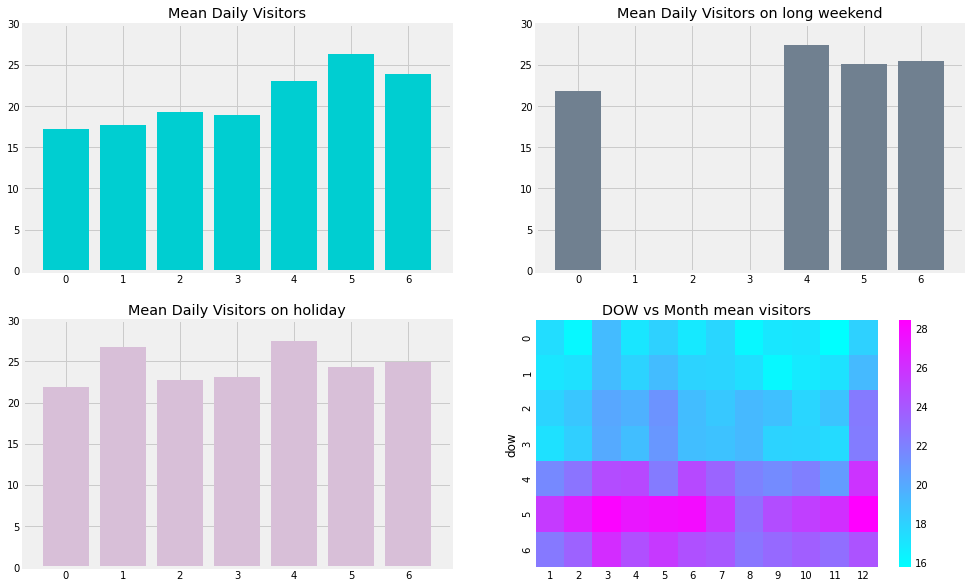

In [ ]:
max_date=max(train['visit_date'])
one_year = datetime.timedelta(days=364)
cmap='cool'
year_ago= max_date - one_year
train2=train#[train['visit_date']>year_ago]
pvt=train2.groupby(['dow','dow_name'])['visitors'].mean().reset_index()

# train2=train.loc[(train['day']<8)&(train['holiday_flg']==1)]
# pvt2=train2.groupby(['dow','dow_name'])['visitors'].mean().reset_index()

train3=train.loc[train['holiday_flg']==1]
pvt3=train3.groupby(['dow','dow_name'])['visitors'].mean().reset_index()
train4=train.loc[(train['long_wknd']==1)]
pvt4=train4.groupby(['dow','dow_name'])['visitors'].mean().reset_index()

pvt5=pd.pivot_table(train, index=['dow'], columns='month',values='visitors',aggfunc=[np.mean],fill_value=0)#.reset_index()
pvt5=pd.DataFrame(pvt5.to_records())
pvt5.columns=[pvt5.replace("('mean', ", "").replace(")", "") for pvt5 in pvt5.columns]
pvt5=pvt5.set_index('dow')

f, ax=plt.subplots(2,2, figsize=(15,10), sharey=False)
ax[0,0].bar(pvt['dow'] ,pvt['visitors'],color='darkturquoise')
# ax[0,1].bar(pvt2['dow'] ,pvt2['visitors'],color='slategrey')
ax[0, 1].bar(pvt4['dow'] ,pvt4['visitors'],color='slategrey')
ax[1,0].bar(pvt3['dow'] ,pvt3['visitors'],color='thistle')
sns.heatmap(pvt5, ax=ax[1,1],cmap=cmap)
ax[0,0].set_title('Mean Daily Visitors')
ax[0,1].set_title('Mean Daily Visitors on long weekend')
ax[1,0].set_title('Mean Daily Visitors on holiday')
ax[1,1].set_title('DOW vs Month mean visitors')

ax[0,0].set_ylim(0,30)
ax[0,1].set_ylim(0,30)
ax[1,0].set_ylim(0,30)
#ax[1,1].set_xlim(0,100)
#plt.xlabel("Month")

요일별 평균 방문자는 일반적으로 금, 토, 일 방문이 가장 많고, 휴일인 경우 목, 화, 금 순서로, 롱 위켄드인 경우에는 금요일에 방문자 수가 가장 많습니다.

In [ ]:
plt1[plt1['visitors']>8000]

,visitors
visit_date,
2016-02-27,8435
2016-03-05,8048
2016-03-12,8185
2016-03-19,8002
2016-03-25,8488
...,...
2017-04-18,13489
2017-04-19,14607
2017-04-20,13990


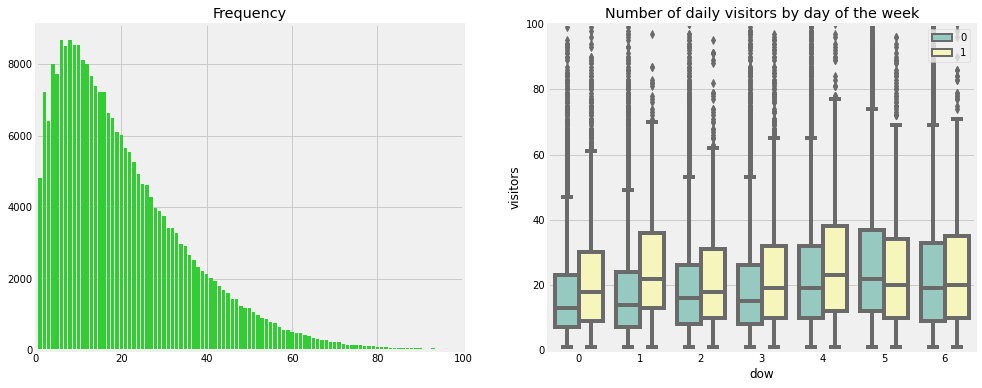

In [ ]:
plt1=train['visitors'].value_counts().reset_index().sort_index()
fig, ax = plt.subplots(figsize=(15, 6), nrows=1, ncols=2, sharex=False, sharey=False)
ax[0].bar(plt1['index'] ,plt1['visitors'],color='limegreen')
ax[1]= sns.boxplot(y='visitors',x='dow', data=train,hue='holiday_flg',palette="Set3")
ax[1].set_title('Number of daily visitors by day of the week')
ax[0].bar(plt1['index'] ,plt1['visitors'],color='limegreen')
ax[0].set_title('Frequency')
ax[0].set_xlim(0,100)
ax[1].set_ylim(0,100)
ax[1].legend(loc=1)

- 방문 인원 수를 보면 4명, 6~12명의 인원의 방문이 가장 많고, 분포는 왼쪽으로 치우쳐 있는 형태를 가진다.
- 토요일을 제외한 휴일에는 평소보다 많은 방문객이 다녀간다.

## 예약 추이

In [ ]:
print('Total air reserve visitors - ',data['ar_hour']['reserve_visitors'].sum())
print('Total hpg reserve visitors - ',data['hr_hour']['reserve_visitors'].sum())

Total air reserve visitors -  414015
Total hpg reserve visitors -  122994


Text(0.5, 1.0, 'Hpg Reserve Hour vs Visit hour')

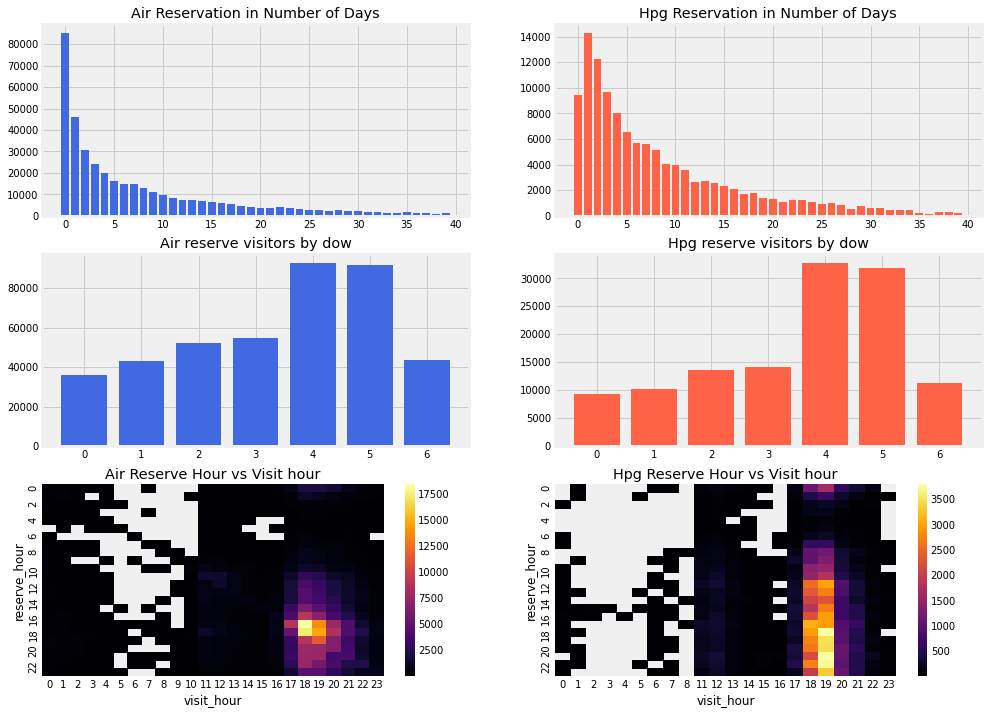

In [ ]:
data['ar_hour']['dow_reserve'] = data['ar_hour']['reserve_datetime'].dt.weekday
data['ar_hour']['dow_visit'] = data['ar_hour']['visit_datetime'].dt.weekday
data['hr_hour']['dow_reserve'] = data['hr_hour']['reserve_datetime'].dt.weekday
data['hr_hour']['dow_visit'] = data['hr_hour']['visit_datetime'].dt.weekday

air_res= data['ar_hour'].groupby(['reserve_day_ar'],as_index=False)['reserve_visitors'].sum()[:40]
hpg_res= data['hr_hour'].groupby(['reserve_day_hr'],as_index=False)['reserve_visitors'].sum()[:40]
air_res2=data['ar_hour'].groupby(['dow_visit',],as_index=False)['reserve_visitors'].sum()
hpg_res2=data['hr_hour'].groupby(['dow_visit',],as_index=False)['reserve_visitors'].sum()
air_res3=data['ar_hour'].groupby(['reserve_hour','visit_hour'])['reserve_visitors'].sum().unstack()
hpg_res3=data['hr_hour'].groupby(['reserve_hour','visit_hour'])['reserve_visitors'].sum().unstack()

f, ax=plt.subplots(3,2, figsize=(15,12),sharey=False)
ax[0,0].bar(air_res['reserve_day_ar'] ,air_res['reserve_visitors'],color='royalblue')
ax[0,1].bar(hpg_res['reserve_day_hr'] ,hpg_res['reserve_visitors'],color='tomato')
ax[1,0].bar(air_res2['dow_visit'] ,air_res2['reserve_visitors'],color='royalblue')
ax[1,1].bar(hpg_res2['dow_visit'] ,hpg_res2['reserve_visitors'],color='tomato')
sns.heatmap(air_res3, ax=ax[2,0],cmap='inferno')
sns.heatmap(hpg_res3, ax=ax[2,1],cmap='inferno')

ax[0,0].set_title('Air Reservation in Number of Days')
ax[0,1].set_title('Hpg Reservation in Number of Days')
ax[1,0].set_title('Air reserve visitors by dow')
ax[1,1].set_title('Hpg reserve visitors by dow')
ax[2,0].set_title('Air Reserve Hour vs Visit hour')
ax[2,1].set_title('Hpg Reserve Hour vs Visit hour')

- 대부분 1주일 전에 예약을 한다. (5일전)
- 금요일과 토요일에 레스토랑을 가장 많이 찾는다.
- 저녁시간의 방문이 많은 편이다.
- HPG 방문자는 하루 전에 예약하는 경우가 많고 AIR 사용자는 당일에 예약하는 경우가 가장 많다.

## air_store의 생산성

In [ ]:
store_mean= train.groupby(['air_store_id'], as_index=False)['visitors'].mean().rename(columns={'visitors':'overall_mean'}) # 가게 당 평균방문객 수
train=pd.merge(train, store_mean, how = 'left',on='air_store_id')

train['vis_qtl']=pd.qcut(train['overall_mean'], 4, labels=['Quartile 4','Quartile 3','Quartile 2','Quartile 1'])
quartile=train.groupby(['vis_qtl'],as_index=False).agg({'air_store_id':lambda x: len(x.unique()),
                                               'mean_visitors':lambda x: x.mean(),
                                               'visitors':lambda x: x.sum()})
quartile.rename(columns={'air_store_id':'stores', 'visitors':'total_visitors'},inplace=True)
quartile.sort_values(by='total_visitors', ascending=False,inplace=True)
quartile['cumulative_visitors'] = quartile['total_visitors'].cumsum()/quartile['total_visitors'].sum() # 누적 방문
quartile

,vis_qtl,stores,mean_visitors,total_visitors,cumulative_visitors
3,Quartile 1,211,35.589254,2257572,0.426952
2,Quartile 2,201,23.461425,1492177,0.709152
1,Quartile 3,204,15.522594,981585,0.894789
0,Quartile 4,213,8.782644,556319,1.000000


레스토랑을 아이디 기준으로 4개의 분위로 나누었다.
1분위, 2분위에 속한 50%정도의 레스토랑이 전체 레스토랑 방문객의 70%를 커버한다.

Text(0.5, 1.0, '%Cumulative visitors  by Store Productivity Quartile')

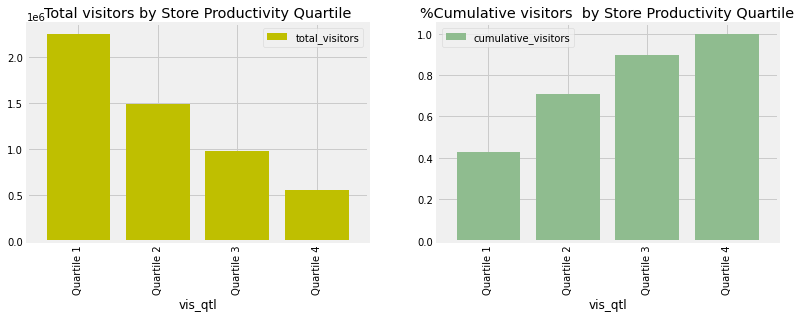

In [ ]:

tot_visitors = quartile[['vis_qtl','total_visitors']]
tot_visitors2 = quartile[['vis_qtl','cumulative_visitors']]
tot_visitors.set_index('vis_qtl',inplace=True)
tot_visitors2.set_index('vis_qtl',inplace=True)
quartile.sort_values(by='total_visitors', ascending=False,inplace=True)
f, ax=plt.subplots(1,2, figsize=(12,4))
tot_visitors.plot(kind='bar',  ax=ax[0],color='y',width=0.8)
tot_visitors2.plot(kind='bar',  ax=ax[1],color='darkseagreen',width=0.8)
ax[0].set_title('Total visitors by Store Productivity Quartile')
ax[1].set_title('%Cumulative visitors  by Store Productivity Quartile')

## Outliers (???)

In [ ]:
# outliers based on air_area_name & dow grouping
area_dow_std_df=train.groupby(['air_area_name','dow'])['visitors'].std().reset_index().rename(columns={'visitors':'std_area_dow'})
area_dow_mean_df=train.groupby(['air_area_name','dow'])['visitors'].mean().reset_index().rename(columns={'visitors':'mean_area_dow'})
train2=pd.merge(train, area_dow_std_df, how="left", on=['air_area_name','dow'])
train2=pd.merge(train2, area_dow_mean_df, how="left", on=['air_area_name','dow'])

x=train2['visitors']
y=train2['mean_area_dow']
z=train2['std_area_dow']
ol_df=[]
for n in range(10):
    train2['ol_{}'.format(n)]= [1 if (x>y+z*n) else 0 for x, y, z in zip(x,y,z)] # 계산식이 이해가 안간다..ㅠㅠㅠ
    ol_dfs=train2['ol_{}'.format(n)].value_counts()
    ol_df.append(ol_dfs)
    
ol_df=pd.DataFrame(ol_df)   
ol_df.index.name='outliers'

Text(100000, 11, 'Outliers')

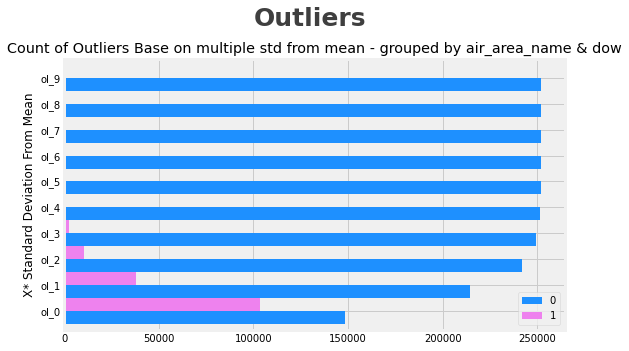

In [ ]:
f, ax=plt.subplots(1,1, figsize=(8,5))
ol_df.plot(kind='barh',width=1,ax=ax, color=['dodgerblue','violet'])
ax.set_title('Count of Outliers Base on multiple std from mean - grouped by air_area_name & dow')
ax.set_ylabel('X* Standard Deviation From Mean')
# Adding a title and a subtitle
plt.text(x = 100000, y = 11, s = "Outliers",fontsize = 25, weight = 'bold', alpha = .75)

# Ref
참조한 노트북: https://www.kaggle.com/faizalabdkadir/recruit-visual-eda-itadakimasu 
-  Data Wrangling이 잘 정리되어 있다.
-  Feature에서 얻을 수 있는 정보들을 모두 쪼개고 새로운 기준으로 데이터를 구조화 시켜서 다양한 시각으로 데이터를 살펴보는 방법을 배울 수 있었다.
- 다양한 시각화 기법이 소개되어 있다
